######   Robust Optimization for Robust Regression ##############
This notebook contains all the optimisers enabled with the various convergence and quality diagnostics presented in the paper: https://arxiv.org/abs/2009.00666, wherein the true posterior belongs to the t-family, and we use a mean field t-distribution as the approximation. The diagnostics also work for full rank and Gaussian approximations. 

In [1]:
import sys, os
sys.path.append('..')
sys.path.append('../..')

In [2]:
import autograd

In [3]:
import pickle

In [4]:
import pystan

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_chivi,
                       make_stan_log_density,
                      )

from experiments import (get_samples_and_log_weights, 
                         improve_with_psis,
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         plot_dist_to_opt_param,
                         check_approx_accuracy,
                         psis_correction,
                         print_bounds)

#from data_generator import (data_generator_linear)

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

In [6]:
from viabel.optimizers import rmsprop_workflow_optimize, adam_workflow_optimize, adagrad_workflow_optimize

# Linear regression model example

We will approximate the posterior for the simple 2D robust linear regression model
$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{1000000}(\beta^\top x_n, 1).$$

We will use Stan to take care of compute log probabilities and gradients for us. 

In [7]:
regression_model_code = """data {
  int<lower=0> N;   // number of observations
  matrix[N, 2] x;   // predictor matrix
  vector[N] y;      // outcome vector
  real<lower=1> df; // degrees of freedom
}
parameters {
  vector[2] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(df, x * beta, 1);  // likelihood
}"""

In [8]:

try:
    sm = pickle.load(open('robust_reg_model_2222.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_2222.pkl', 'wb') as f:
        pickle.dump(sm, f)


We generate 25 observations from the model with $\beta = (-2, 1)$.

In [9]:
np.random.seed(5039)
beta_gen = np.array([-2, 1])
N = 25
x = np.random.randn(N, 2).dot(np.array([[1,.25],[.25, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(40, N)
y = y_raw - np.mean(y_raw)

First, we generate ground truth samples using Stan's dynamic HMC implementation

In [10]:
data = dict(N=N, x=x, y=y, df=40)
fit = sm.sampling(data=data, iter=40000, thin=50, chains=4)

In [11]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)

In [12]:
true_std = np.sqrt(np.diag(true_cov))
true_var = np.diag(true_cov)

In [13]:
print(true_mean)
print(np.log(true_std))
logdensity = make_stan_log_density(sm)

[-2.16381902  1.09138953]
[-1.45960752 -1.4144648 ]


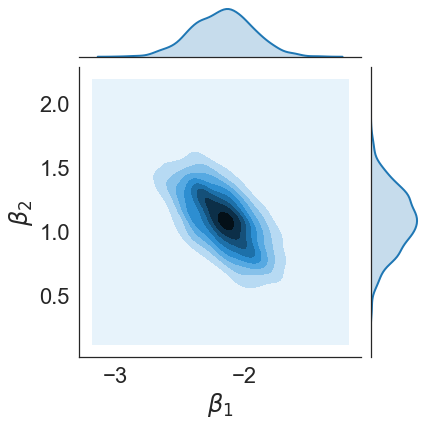

In [14]:
jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
plt.show()

## Standard mean-field variational inference

Next, we compute a mean field variational approximation using standard variational inference (that is, minimizing the KL-divergence)

####  First we use mean field t as proposal density

#### RMSProp Optimizer

Average Loss = 28.3562:  18%|█▊        | 1106/6000 [00:18<01:52, 43.44it/s]

Rhat- All means converged ...


Average Loss = 23.1187:  27%|██▋       | 1604/6000 [00:32<02:10, 33.71it/s]

Rhat- All sigmas converged ...


Average Loss = 23.0757:  42%|████▏     | 2497/6000 [01:03<01:28, 39.52it/s]


Optimization Stopping reliably!


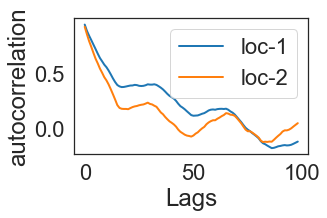

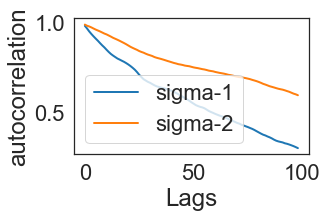

In [15]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(2, 40)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)
k=2
init_mean    = np.zeros(2)
init_log_std = np.ones(2)
init_var_param = np.array([-2.5, 1.5, -0.4, -0.4])
init_mean    = np.zeros(k)
#init_mean_random = np.random.normal([k], stddev=1.0)
init_log_std = np.ones(k)
#init_log_std_random = tf.random.normal([k], stddev=1.)
init_var_param1 = np.concatenate([init_mean, init_log_std])
n_iters = 6000

klvi_var_param,  klvi_param_history, avg_mean, avg_sigmas, klvi_history, grad_norm_history,oplog = \
   rmsprop_workflow_optimize(n_iters, klvi_objective_and_grad, init_var_param1, K=2, learning_rate=.01, learning_rate_end=0.0001, stopping_rule=2, r_mean_threshold=1.1, r_sigma_threshold=1.4,  epsilon=0.2, plotting=True)

Since the mean field approximation is not good for this problem, we observe the
high autocorrelation in the plots above.

In [16]:
print('HMC parameters:')
print(true_mean)
print(np.log(true_std))

HMC parameters:
[-2.16381902  1.09138953]
[-1.45960752 -1.4144648 ]


In [17]:
print('variational parameters:')
print(klvi_var_param)


variational parameters:
[-2.1519338   1.08630619 -1.75239434 -1.68682441]


Text(0.5, 0, 'Iterations')

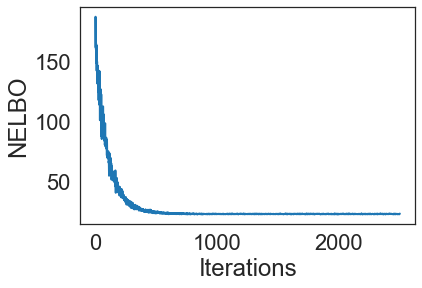

In [18]:
plt.plot(klvi_history)
plt.ylabel('NELBO')
plt.xlabel('Iterations')

####  Let us compare the RMSPROP and RMSPROP(IA) solutions in terms of moment-l2 distance and khat

In [19]:
ia_var_params=  np.concatenate((avg_mean[0], avg_sigmas[0]), axis=0)
cov_iters_fr_rms = mf_t_var_family.mean_and_cov(klvi_var_param)[1]
cov_iters_fr_rms_ia = mf_t_var_family.mean_and_cov(ia_var_params)[1]
print('Difference between analytical mean and HMC mean:', np.sqrt(np.mean(np.square(klvi_var_param[:k].flatten() - true_mean.flatten()))))
print('Difference between analytical cov and HMC cov:', np.sqrt(np.mean(np.square(np.diag(cov_iters_fr_rms).flatten() - true_var.flatten()))))

print('Difference between analytical mean and HMC mean-IA:', np.sqrt(np.mean(np.square(ia_var_params[:k].flatten() - true_mean.flatten()))))
print('Difference between analytical cov and HMC cov-IA:', np.sqrt(np.mean(np.square(np.diag(cov_iters_fr_rms_ia).flatten() - true_var.flatten()))))

Difference between analytical mean and HMC mean: 0.00914052916040684
Difference between analytical cov and HMC cov: 0.022677180813668416
Difference between analytical mean and HMC mean-IA: 0.008739969694593612
Difference between analytical cov and HMC cov-IA: 0.02281325291356334


##### ADAM Optimizer 

Average Loss = 24.0319:  18%|█▊        | 1106/6000 [00:11<01:02, 78.75it/s]

Rhat- All mean converged ...


Average Loss = 23.0869:  37%|███▋      | 2206/6000 [00:29<01:22, 46.19it/s]

Rhat- All sigmas converged ...


Average Loss = 23.0834:  47%|████▋     | 2798/6000 [00:42<00:48, 66.31it/s]


Optimization stopping reliably!


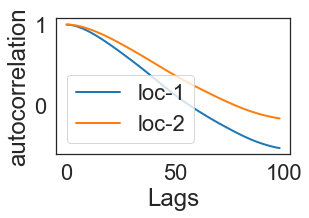

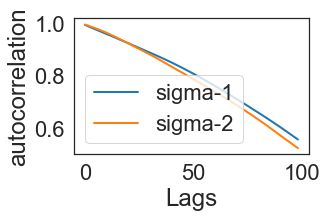

In [20]:
####
klvi_var_param_adam,  klvi_param_history_adam, avg_mean_adam, avg_sigmas_adam, klvi_history_adam, grad_norm_history_adam,oplog_adam = \
   adam_workflow_optimize(n_iters, klvi_objective_and_grad, init_var_param, K=2, learning_rate=.01, learning_rate_end=0.0001, stopping_rule=2, window=200, r_mean_threshold=1.1, r_sigma_threshold=1.7,  epsilon=0.2, plotting=True)

#### Windowed Adagrad  Optimizer 

Let us use the full rank Gaussian distribution as the approximation ...

In [21]:
fr_g_var_family  = t_variational_family(2, 400000000)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(fr_g_var_family, stan_log_density, 50)
k=2
init_var_param = np.zeros(fr_g_var_family.var_param_dim)

init_mean    = np.zeros(k)
#init_mean_random = np.random.normal([k], stddev=1.0)
init_log_std = np.ones(k)
#init_log_std_random = tf.random.normal([k], stddev=1.)
init_var_param1 = np.concatenate([init_mean, init_log_std])
n_iters = 6000

Rhat- All sigmas converged ...
Rhat- All means converged ...
Optimization stopping reliably!


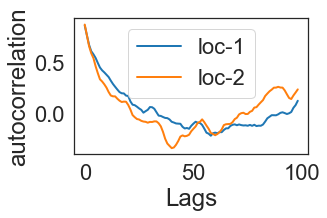

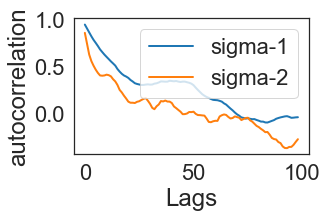

In [23]:
klvi_var_param_avg_adagrad_fr,  klvi_param_history_adagrad_fr, klvi_history_adagrad_fr, grad_norm_history_adam_fr, oplog_adagrad_fr = \
   adagrad_workflow_optimize(8000, klvi_objective_and_grad, init_var_param, K=2, learning_rate=.015, learning_rate_end=0.001, stopping_rule=2, window=20, r_mean_threshold=1.1, r_sigma_threshold=1.4,  epsilon=0.2, plotting=True)

In [24]:
fn_density = fr_g_var_family
n_samples= 800000

In [25]:
samples, smoothed_log_weights, khat = psis_correction(stan_log_density, fn_density,
                                                              klvi_param_history_adagrad_fr[-1], n_samples)
samples_ia, smoothed_log_weights_ia, khat_ia = psis_correction(stan_log_density, fn_density,
                                                                       klvi_var_param_avg_adagrad_fr, n_samples)




/Users/akashd/Desktop/research_repos/viabel/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


In [27]:
print('khat:', khat)
print('khat IA:', khat_ia)
print(true_mean)
print(klvi_param_history_adagrad_fr[-1][:k])

cov_iters_fr_rms = fn_density.mean_and_cov(klvi_param_history_adagrad_fr[-1])[1]
cov_iters_fr_rms_ia1 = fn_density.mean_and_cov(klvi_var_param_avg_adagrad_fr)[1]
print('Difference between analytical mean and HMC mean:',
              np.sqrt(np.mean(np.square(klvi_param_history_adagrad_fr[-1][:k].flatten() - true_mean.flatten()))))
print('Difference between analytical cov and HMC cov:',
              np.sqrt(np.mean(np.square(cov_iters_fr_rms.flatten() - true_cov.flatten()))))

print('Difference between analytical mean and HMC mean-IA:',
              np.sqrt(np.mean(np.square(klvi_var_param_avg_adagrad_fr[:k].flatten() - true_mean.flatten()))))
print('Difference between analytical cov and HMC cov-IA:',
              np.sqrt(np.mean(np.square(cov_iters_fr_rms_ia1.flatten() - true_cov.flatten()))))

khat: 0.2134816712167272
khat IA: 0.2306200946214539
[-2.16381902  1.09138953]
[-2.15187803  1.08422249]
Difference between analytical mean and HMC mean: 0.009847677490989892
Difference between analytical cov and HMC cov: 0.0016450402974546093
Difference between analytical mean and HMC mean-IA: 0.009518139676748642
Difference between analytical cov and HMC cov-IA: 0.0015155981627124559
